In [1]:
import os 
os.chdir("..")
from src.cpwc.multires.class_multiressolver import *
import matplotlib.pyplot as plt
import torch
from src.cpwc.tools.ptychography import Ptychography as Ptychography
from src.cpwc.tools.utils import *
torch.cuda.empty_cache()

# Set seeds 
torch.manual_seed(0)
np.random.seed(0)

/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) and obj.is_cuda:
            print(type(obj), obj.size())
    except Exception:
        pass

cycle = [0, -1, -1, -1,  1, 1, 1]
lmbda = 0
tol = [1e-10] * 9
tol_in = [1e-10] * 9
device = 'cuda'
max_scale = 9
max_probe_size = 128
def extract_data(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):  # If the item is a list, recurse into it
            result.extend(extract_data(item))
        else:  # If the item is not a list, add it to the result
            result.append(item)
    return result

def unwrap_2d(phase):
    """
    Unwraps a 2D phase array using NumPy's 1D unwrap function.
    
    Parameters:
    phase (numpy array): The 2D phase array to be unwrapped.
    
    Returns:
    unwrapped_phase (numpy array): The 2D unwrapped phase array.
    """
    # Unwrap along the first axis (rows)
    unwrapped_phase = np.unwrap(phase, axis=0)
    
    # Unwrap along the second axis (columns)
    unwrapped_phase = np.unwrap(unwrapped_phase, axis=1)
    
    return unwrapped_phase

def get_ring_average(ground_truth, estimate, delta_radius=1):
    size = ground_truth.shape[0]
    center = size//2
    
    x = np.linspace(0, size, size, dtype=np.uint)
    xx, yy = np.meshgrid(x, x, indexing="ij") 
    r2 = ((xx-center)**2 + (yy-center)**2)

    ring_average = torch.empty(center)
    for radius in range(center):
        mask = (r2 >= radius**2) * (r2 < (radius+delta_radius)**2)
        vec1 = ground_truth[mask].flatten()
        vec2 = estimate[mask].flatten()
        ring_average[radius] = torch.abs(torch.dot(vec1, vec2.conj())) / (torch.norm(vec1) * torch.norm(vec2))
    return np.array(ring_average)


def save_data(model,model_name,image):
    image = (image - image.min())/(image.max() - image.min()) 
    image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**max_scale, 2**max_scale)
    image_tensor_ = torch.exp(1j * image_tensor)
    image = image[::,::]
    mean_img = np.mean(image)
    loss_data = extract_data(model.measures["loss"])
    cos_sim = extract_data(model.measures["csim"])
    phase = torch.angle(model.c_k[0,0,:,:].to('cpu'))
    phase = phase.numpy()
    phase = unwrap_2d(phase)
    phase += (mean_img-np.mean(phase)) 
    psnr = extract_data(model.measures["psnr"])
    ring_average = get_ring_average(image_tensor_[0,0,:,:], model.c_k[0,0,:,:])
    np.save("np_data/{}_ring_average.npy".format(model_name), ring_average)
    np.save("np_data/{}_overlap_loss.npy".format(model_name), loss_data)
    np.save("np_data/{}_overlap_csim.npy".format(model_name), cos_sim)
    np.save("np_data/{}_overlap_image.npy".format(model_name), phase)
    np.save("np_data/{}_overlap_psnr.npy".format(model_name), psnr)

/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:181: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


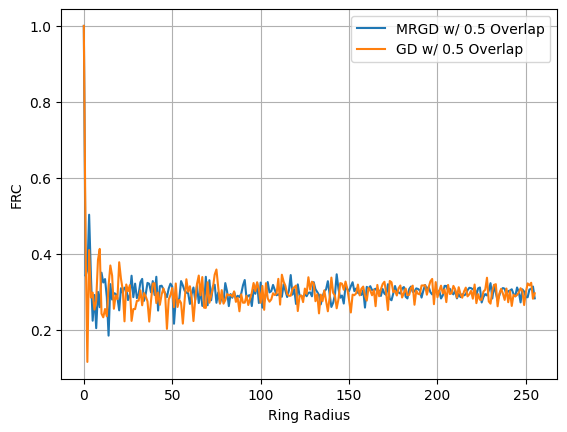

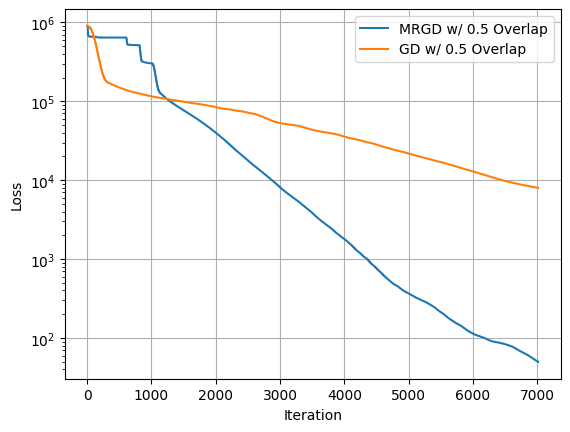

In [9]:

frc1 = np.load("np_data/50_overlap_ring_average.npy")
frc2 = np.load("np_data/50_overlap_gd_ring_average.npy")

loss1 = np.load("np_data/50_overlap_overlap_loss.npy")
loss2 = np.load("np_data/50_overlap_gd_overlap_loss.npy")
plt.figure()
plt.plot(frc1, label="MRGD w/ 0.5 Overlap")
plt.plot(frc2, label="GD w/ 0.5 Overlap")
plt.xlabel("Ring Radius")
plt.ylabel("FRC")
plt.grid()
plt.legend()
plt.show()

plt.figure()
plt.semilogy(loss1, label="MRGD w/ 0.5 Overlap")
plt.semilogy(loss2, label="GD w/ 0.5 Overlap")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.legend()




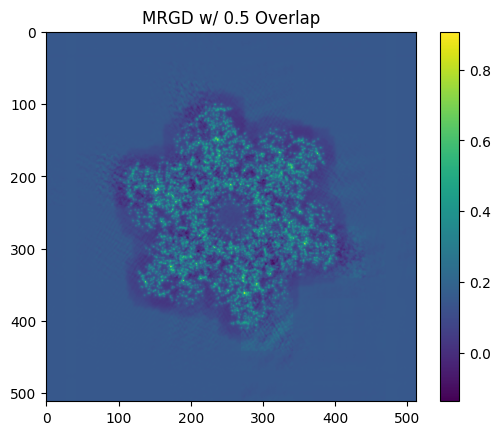

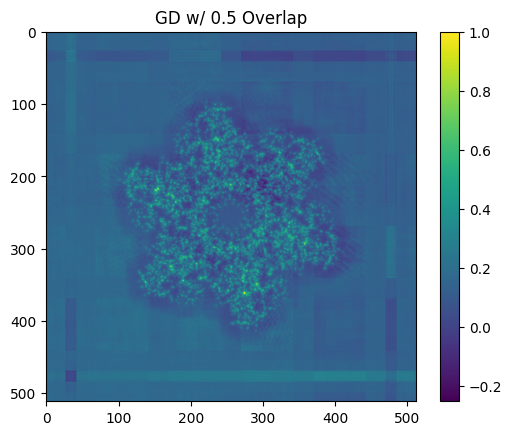

In [15]:
image1 = np.load("np_data/25_overlap_overlap_image.npy")
image2 = np.load("np_data/25_overlap_gd_overlap_image.npy")

plt.figure()
plt.imshow(image1)
plt.colorbar()
plt.title("MRGD w/ 0.5 Overlap")
plt.show()

plt.figure()
plt.imshow(image2)
plt.colorbar()
plt.title("GD w/ 0.5 Overlap")
plt.show()


In [ ]:


# % 75 Overlap w/ MRGD
LR = 1e-2
max_shift = 32
I_in = 15*np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 10*np.array([0, 0, 0, 30, 10,10,300])
linOperator = Ptychography(max_scale = max_scale,max_probe_size = max_probe_size ,max_shift = max_shift,device=device)
image = np.load("test_data/potential.npy")
image = (image - image.min())/(image.max() - image.min()) 
image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**max_scale, 2**max_scale)
image_tensor_ = torch.exp(1j * image_tensor)

multires = MultiRes(max_scale, device)
image_tensor__ = linOperator.apply(image_tensor_)
loss = Loss(linOperator,image_tensor__,lmbda= 1e-9)
model75 = MultiResSolver(multires, loss, LR = LR,
                        I_in = I_in,
                        I_out = I_out,
                        tol = tol,
                        tol_in = tol_in,
                        cycle = cycle,
                        l1_type = "l1_row",
                        gt = image_tensor_)

model75.solve_multigrid()
model75.print_time()
save_data(model75,"75_overlap",image)
    



In [3]:
# % 50 Overlap w/ MRGD
LR = 1e-2
max_shift = 64
I_in = 15*np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 10*np.array([0, 0, 0, 30, 10,10,300])
linOperator = Ptychography(max_scale = max_scale,max_probe_size = max_probe_size ,max_shift = max_shift,device=device)
image = np.load("test_data/potential.npy")
image = (image - image.min())/(image.max() - image.min()) 
image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**max_scale, 2**max_scale)
image_tensor_ = torch.exp(1j * image_tensor)

noise_level = 0.1
image_tensor__ = np.random.poisson(image_tensor_.cpu().detach() * noise_level) / noise_level
image_tensor__ = torch.tensor(image_tensor__).to(torch.complex64).to(device)


multires = MultiRes(max_scale, device)
image_tensor__ = linOperator.apply(image_tensor__)
loss = Loss(linOperator,image_tensor__,lmbda = 1e-9)
model50 = MultiResSolver(multires, loss, LR = LR,
                        I_in = I_in,
                        I_out = I_out,
                        tol = tol,
                        tol_in = tol_in,
                        cycle = cycle,
                        l1_type = "l1_row",
                        gt = image_tensor_)

model50.solve_multigrid()
model50.print_time()
save_data(model50,"50_overlap",image)


/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/src/cpwc/multires/class_multiressolver.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.gt = torch.tensor(gt).double().to(self.loss.F.device)
/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/src/cpwc/multires/class_multiressolver.py:55: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:250.)
  self.gt = torch.tensor(gt).double().to(self.loss.F.device)


----------- s = 9 -----------
----------- s = 8 -----------
----------- s = 7 -----------
----------- s = 6 -----------
1
Iter 1, [loss,frc,csm,gt_mse,psnr,mse, reg, rel_loss, LR] : [896531.9479181, 0.0021045, 0.9749435, 0.1102053, 896531.9479178, 3e-07, 0.1773298, 0.01] 
1
Iter 2, [loss,frc,csm,gt_mse,psnr,mse, reg, rel_loss, LR] : [737550.112306, 0.0213625, 1.5572709, -1.9236418, 737550.1122968, 9.2e-06, 0.0516887, 0.01] 
1
Iter 3, [loss,frc,csm,gt_mse,psnr,mse, reg, rel_loss, LR] : [699427.1377282, 0.0480588, 2.2184982, -3.4605908, 699427.1377152, 1.3e-05, 0.0176259, 0.01] 
1
Iter 4, [loss,frc,csm,gt_mse,psnr,mse, reg, rel_loss, LR] : [687099.132541, 0.0706035, 2.7056234, -4.3226735, 687099.1325258, 1.52e-05, 0.0078768, 0.01] 
1
Iter 5, [loss,frc,csm,gt_mse,psnr,mse, reg, rel_loss, LR] : [681686.9605381, 0.0936105, 2.9673654, -4.7237103, 681686.9605221, 1.61e-05, 0.0063095, 0.01] 
1
Iter 6, [loss,frc,csm,gt_mse,psnr,mse, reg, rel_loss, LR] : [677385.8867788, 0.1215836, 3.1064566, -4

In [ ]:
# % 25 Overlap w/ MRGD
LR = 1e-2
max_shift = 96
I_in = 15*np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 10*np.array([0, 0, 0, 30, 10,10,300])
linOperator = Ptychography(max_scale = max_scale,max_probe_size = max_probe_size ,max_shift = max_shift,device=device)
image = np.load("test_data/potential.npy")
image = (image - image.min())/(image.max() - image.min()) 
image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**max_scale, 2**max_scale)
image_tensor_ = torch.exp(1j * image_tensor)

multires = MultiRes(max_scale, device)
image_tensor__ = linOperator.apply(image_tensor_)
loss = Loss(linOperator,image_tensor__)
model25 = MultiResSolver(multires, loss, LR = LR,
                        I_in = I_in,
                        I_out = I_out,
                        tol = tol,
                        tol_in = tol_in,
                        cycle = cycle,
                        l1_type = "l1_row",
                        gt  = image_tensor_)

model25.solve_multigrid()
model25.print_time()
save_data(model25,"25_overlap",image)


In [ ]:
# % 75 Overlap w/ GD 
LR = 1e-3
max_shift = 32
I_in = 15*np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 10*np.array([0, 0, 0, 0, 0,0,350])
linOperator = Ptychography(max_scale = max_scale,max_probe_size = max_probe_size ,max_shift = max_shift,device=device)
image = np.load("test_data/potential.npy")
image = (image - image.min())/(image.max() - image.min()) 
image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**max_scale, 2**max_scale)
image_tensor_ = torch.exp(1j * image_tensor)

multires = MultiRes(max_scale, device)
image_tensor__ = linOperator.apply(image_tensor_)
loss = Loss(linOperator,image_tensor__)
modelu75 = MultiResSolver(multires, loss, LR = LR,
                        I_in = I_in,
                        I_out = I_out,
                        tol = tol,
                        tol_in = tol_in,
                        cycle = cycle,
                        l1_type = "l1_row",
                        gt = image_tensor_)

modelu75.solve_multigrid()
modelu75.print_time()
save_data(modelu75,"75_overlap_gd",image)

In [4]:
# % 50 Overlap w/ GD 
LR = 1e-3
max_shift = 64
I_in = 15*np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 10*np.array([0, 0, 0, 0, 0,0,350])
linOperator = Ptychography(max_scale = max_scale,max_probe_size = max_probe_size ,max_shift = max_shift,device=device)
image = np.load("test_data/potential.npy")
image = (image - image.min())/(image.max() - image.min()) 
image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**max_scale, 2**max_scale)
image_tensor_ = torch.exp(1j * image_tensor)

noise_level = 0.1
image_tensor__ = np.random.poisson(image_tensor_.cpu().detach() * noise_level) / noise_level
image_tensor__ = torch.tensor(image_tensor__).to(torch.complex64).to(device)


multires = MultiRes(max_scale, device)
image_tensor__ = linOperator.apply(image_tensor__)
loss = Loss(linOperator,image_tensor__,lmbda = 1e-9)
modelu50 = MultiResSolver(multires, loss, LR = LR,
                        I_in = I_in,
                        I_out = I_out,
                        tol = tol,
                        tol_in = tol_in,
                        cycle = cycle,
                        l1_type = "l1_row",
                        gt = image_tensor_)

modelu50.solve_multigrid()
modelu50.print_time()
save_data(modelu50,"50_overlap_gd",image)

/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/.venv/lib/python3.8/site-packages/torch/_tensor.py:759: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)
/home/efe/Desktop/Multiresolution-Framework-for-Fourier-Ptychography/src/cpwc/multires/class_multiressolver.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.gt = torch.tensor(gt).double().to(self.loss.F.device)


----------- s = 9 -----------
----------- s = 8 -----------
----------- s = 7 -----------
----------- s = 6 -----------
----------- s = 7 -----------
----------- s = 8 -----------
----------- s = 9 -----------
1
Iter 1, [loss,frc,csm,gt_mse,psnr,mse, reg, rel_loss, LR] : [894852.4188284, 0.0048038, 0.9748244, 0.1107362, 894852.4188282, 3e-07, 0.0008276, 0.001] 
1
Iter 2, [loss,frc,csm,gt_mse,psnr,mse, reg, rel_loss, LR] : [894111.8038091, 0.0052571, 0.9748397, 0.1106681, 894111.8038084, 7e-07, 0.0009116, 0.001] 
1
Iter 3, [loss,frc,csm,gt_mse,psnr,mse, reg, rel_loss, LR] : [893296.7376354, 0.005592, 0.9748639, 0.1105603, 893296.7376342, 1.2e-06, 0.0012078, 0.001] 
1
Iter 4, [loss,frc,csm,gt_mse,psnr,mse, reg, rel_loss, LR] : [892217.7979973, 0.0057881, 0.9749125, 0.1103438, 892217.7979954, 1.9e-06, 0.0015025, 0.001] 
1
Iter 5, [loss,frc,csm,gt_mse,psnr,mse, reg, rel_loss, LR] : [890877.2630731, 0.0059017, 0.9749892, 0.110002, 890877.2630703, 2.8e-06, 0.0017968, 0.001] 
1
Iter 6, [loss,

In [ ]:
# % 25 Overlap w/ GD 
LR = 1e-3
max_shift = 96
I_in = 15*np.array([1, 15, 10, 5, 10, 30, 100])
I_out = 10*np.array([0, 0, 0, 0, 0,0,350])
linOperator = Ptychography(max_scale = max_scale,max_probe_size = max_probe_size ,max_shift = max_shift,device=device)
image = np.load("test_data/potential.npy")
image = (image - image.min())/(image.max() - image.min()) 
image_tensor = torch.tensor(image).double().to(device).view(1, 1, 2**max_scale, 2**max_scale)
image_tensor_ = torch.exp(1j * image_tensor)

multires = MultiRes(max_scale, device)
image_tensor__ = linOperator.apply(image_tensor_)
loss = Loss(linOperator,image_tensor__)
modelu25 = MultiResSolver(multires, loss, LR = LR,
                        I_in = I_in,
                        I_out = I_out,
                        tol = tol,
                        tol_in = tol_in,
                        cycle = cycle,
                        l1_type = "l1_row",
                        gt = image_tensor_)

modelu25.solve_multigrid()
modelu25.print_time()
save_data(modelu25,"25_overlap_gd",image)

In [ ]:
import os 
os.chdir("..")
from src.cpwc.multires.class_multiressolver import *
import matplotlib.pyplot as plt
import torch
from src.cpwc.tools.ptychography import Ptychography as Ptychography
from src.cpwc.tools.utils import *
torch.cuda.empty_cache()

# Set seeds 
torch.manual_seed(0)
np.random.seed(0)

model75loss = np.load("np_data/75_overlap_overlap_loss.npy")
model50loss = np.load("np_data/50_overlap_overlap_loss.npy")
model25loss = np.load("np_data/25_overlap_overlap_loss.npy")

model75csim = np.load("np_data/75_overlap_overlap_csim.npy")
model50csim = np.load("np_data/50_overlap_overlap_csim.npy")
model25csim = np.load("np_data/25_overlap_overlap_csim.npy")

modelu75loss = np.load("np_data/75_overlap_gd_overlap_loss.npy")
modelu50loss = np.load("np_data/50_overlap_gd_overlap_loss.npy")
modelu25loss = np.load("np_data/25_overlap_gd_overlap_loss.npy")

modelu75csim = np.load("np_data/75_overlap_gd_overlap_csim.npy")
modelu50csim = np.load("np_data/50_overlap_gd_overlap_csim.npy")
modelu25csim = np.load("np_data/25_overlap_gd_overlap_csim.npy")



In [ ]:
plt.figure(figsize=(10, 5),dpi = 200)
plt.semilogy(model75loss,label = "MRGD w/ 0.75 Overlap",color = 'blue', linestyle='-',linewidth = 1,markersize = 1)
plt.semilogy(modelu75loss,label = "GD w/ 0.75 Overlap",color = 'blue', linestyle='--',linewidth = 1,markersize = 1)
plt.semilogy(model50loss,label = "MRGD w/ 0.5 Overlap",color = 'red', linestyle='-',linewidth = 1,markersize = 1)
plt.semilogy(modelu50loss,label = "GD w/ 0.5 Overlap",color = 'red', linestyle='--',linewidth = 1,markersize = 1)
plt.semilogy(model25loss,label = "MRGD w/ 0.25 Overlap",color = 'black', linestyle='-',linewidth = 1,markersize = 1)
plt.semilogy(modelu25loss,label = "GD w/ 0.25 Overlap",color = 'black', linestyle='--',linewidth = 1,markersize = 1)
plt.xlabel("Iterations")
plt.ylabel(r"$Log(\||A\hat{x}|-\sqrt{y}\|^2)$")
plt.grid()
plt.tight_layout()
plt.legend()
plt.savefig("nnfigs/comp_overlap.png")


In [ ]:
plt.figure(figsize=(16, 8),dpi = 200)
plt.semilogy(1-model75csim,label = "MRGD w/ 0.75 Overlap",color = 'blue', linestyle='-',linewidth = 1,markersize = 1)
plt.semilogy(1-modelu75csim,label = "GD w/ 0.75 Overlap",color = 'blue', linestyle='--',linewidth = 1,markersize = 1)
plt.semilogy(1-model50csim,label = "MRGD w/ 0.5 Overlap",color = 'red', linestyle='-',linewidth = 1,markersize = 1)
plt.semilogy(1-modelu50csim,label = "GD w/ 0.5 Overlap",color = 'red', linestyle='--',linewidth = 1,markersize = 1)
plt.semilogy(1-model25csim,label = "MRGD w/ 0.25 Overlap",color = 'black', linestyle='-',linewidth = 1,markersize = 1)
plt.semilogy(1-modelu25csim,label = "GD w/ 0.25 Overlap",color = 'black', linestyle='--',linewidth = 1,markersize = 1)
plt.xlabel("Iterations")
plt.ylabel("log(1 - Cosine Similarity)")
plt.grid()
plt.tight_layout()
plt.legend()
plt.savefig("nnfigs/comp_overlap_csim.png")


In [ ]:
model75image = np.load("np_data/75_overlap_overlap_image.npy")
model50image = np.load("np_data/50_overlap_overlap_image.npy")
model25image = np.load("np_data/25_overlap_overlap_image.npy")

modelu75image = np.load("np_data/75_overlap_gd_overlap_image.npy")
modelu50image = np.load("np_data/50_overlap_gd_overlap_image.npy")
modelu25image = np.load("np_data/25_overlap_gd_overlap_image.npy")



In [ ]:
plt.figure(figsize=(10, 5),dpi = 200)
plt.imshow(model75image,cmap = "gray")
plt.axis("off")
plt.title("MRGD w/ 0.75 Overlap")
plt.savefig("nnfigs/75_overlap.png")

plt.figure(figsize=(10, 5),dpi = 200)
plt.imshow(model50image,cmap = "gray")
plt.axis("off")
plt.title("MRGD w/ 0.5 Overlap")
plt.savefig("nnfigs/50_overlap.png")

plt.figure(figsize=(10, 5),dpi = 200)
plt.imshow(model25image,cmap = "gray")
plt.axis("off")
plt.title("MRGD w/ 0.25 Overlap")
plt.savefig("nnfigs/25_overlap.png")

plt.figure(figsize=(10, 5),dpi = 200)
plt.imshow(modelu75image,cmap = "gray")
plt.axis("off")
plt.title("GD w/ 0.75 Overlap")
plt.savefig("nnfigs/u75_overlap.png")

plt.figure(figsize=(10, 5),dpi = 200)
plt.imshow(modelu50image,cmap = "gray")
plt.axis("off")
plt.title("GD w/ 0.5 Overlap")
plt.savefig("nnfigs/u50_overlap.png")

plt.figure(figsize=(10, 5),dpi = 200)
plt.imshow(modelu25image,cmap = "gray")
plt.axis("off")
plt.title("GD w/ 0.25 Overlap")
plt.savefig("nnfigs/u25_overlap.png")


In [ ]:
def extract_data(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):  # If the item is a list, recurse into it
            result.extend(extract_data(item))
        else:  # If the item is not a list, add it to the result
            result.append(item)
    return result


plt.figure(figsize=(10, 5),dpi = 200)
plt.semilogy(extract_data(model75.measures["loss"]),label = "MRGD w/ 0.75 Overlap",color = 'blue', linestyle='-',linewidth = 1,markersize = 1)
plt.semilogy(extract_data(modelu75.measures["loss"]),label = "GD w/ 0.75 Overlap",color = 'blue', linestyle='--',linewidth = 1,markersize = 1)
plt.semilogy(extract_data(model50.measures["loss"]),label = "MRGD w/ 0.5 Overlap",color = 'red', linestyle='-',linewidth = 1,markersize = 1)
plt.semilogy(extract_data(modelu50.measures["loss"]),label = "GD w/ 0.5 Overlap",color = 'red', linestyle='--',linewidth = 1,markersize = 1)
plt.semilogy(extract_data(model25.measures["loss"]),label = "MRGD w/ 0.25 Overlap",color = 'black', linestyle='-',linewidth = 1,markersize = 1)
plt.semilogy(extract_data(modelu25.measures["loss"]),label = "GD w/ 0.25 Overlap",color = 'black', linestyle='--',linewidth = 1,markersize = 1)
plt.xlabel("Iterations")
plt.ylabel(r"$Log(\||A\hat{x}|-\sqrt{y}\|^2)$")
plt.grid()
plt.tight_layout()
plt.legend()
plt.savefig("nnfigs/comp_overlap.png")


In [ ]:
def extract_data(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):  # If the item is a list, recurse into it
            result.extend(extract_data(item))
        else:  # If the item is not a list, add it to the result
            result.append(item)
    return result


plt.figure(figsize=(10, 5),dpi = 200)
plt.semilogy(extract_data(model75.measures["cosine similarity"]),label = "MRGD w/ 0.75 Overlap",color = 'blue', linestyle='-',linewidth = 1,markersize = 1)
plt.semilogy(extract_data(modelu75.measures["cosine similarity"]),label = "GD w/ 0.75 Overlap",color = 'blue', linestyle='--',linewidth = 1,markersize = 1)
plt.semilogy(extract_data(model50.measures["cosine similarity"]),label = "MRGD w/ 0.5 Overlap",color = 'red', linestyle='-',linewidth = 1,markersize = 1)
plt.semilogy(extract_data(modelu50.measures["cosine similarity"]),label = "GD w/ 0.5 Overlap",color = 'red', linestyle='--',linewidth = 1,markersize = 1)
plt.semilogy(extract_data(model25.measures["cosine similarity"]),label = "MRGD w/ 0.25 Overlap",color = 'black', linestyle='-',linewidth = 1,markersize = 1)
plt.semilogy(extract_data(modelu25.measures["cosine similarity"]),label = "GD w/ 0.25 Overlap",color = 'black', linestyle='--',linewidth = 1,markersize = 1)
plt.xlabel("Iterations")
plt.ylabel(r"Cosine Similarity")
plt.grid()
plt.tight_layout()
plt.legend()
plt.savefig("nnfigs/comp_overlap2.png")


In [ ]:
def unwrap_2d(phase):
    """
    Unwraps a 2D phase array using NumPy's 1D unwrap function.
    
    Parameters:
    phase (numpy array): The 2D phase array to be unwrapped.
    
    Returns:
    unwrapped_phase (numpy array): The 2D unwrapped phase array.
    """
    # Unwrap along the first axis (rows)
    unwrapped_phase = np.unwrap(phase, axis=0)
    
    # Unwrap along the second axis (columns)
    unwrapped_phase = np.unwrap(unwrapped_phase, axis=1)
    
    return unwrapped_phase

def plot_results(model,image):
    plt.figure(figsize=(18, 5),dpi = 200)    
    image = image[::,::]
    mean_img = np.mean(image)
    plt.subplot(1, 3, 1)
    plt.imshow(image,cmap='gray')
    plt.title(r"(a) Phase of GT $(\angle x)$")
    plt.colorbar()


    plt.subplot(1, 3, 2)
    phase = torch.angle(model.c_k[0,0,:,:].to('cpu'))
    phase = phase.numpy()
    phase = unwrap_2d(phase)
    phase += (mean_img-np.mean(phase))
    
    #phase = (phase - np.min(phase))/(np.max(phase) - np.min(phase))
    plt.imshow(phase,cmap = 'gray')
    plt.title(r"(b) Phase of Reconstruction $(\angle \hat{x})$")
    plt.colorbar()


    plt.subplot(1, 3, 3)
    error = np.abs(np.array(image)-np.array(phase))**2
    plt.imshow(error,cmap='gray')
    plt.title(r"(c) $||\angle x - \angle \hat{x}||^2$")
    plt.colorbar()
    plt.tight_layout()
    #plt.savefig("n_figs/new_result_img.png")
    #plt.savefig("n_figs/new_result_img.eps")
    mean_error = np.mean(error)
    print(mean_error)
    return None 

plot_results(model75,image)

In [ ]:
plot_results(model50,image)

In [ ]:
plot_results(model25,image)

In [ ]:
plot_results(modelu75,image)

In [ ]:
plot_results(modelu50,image)

In [ ]:
plot_results(modelu25,image)